## Template for providing an AlphaFold complex and couplings from evcouplings pipeline to generate a contact-coupling map

- receive a contact map that marks residues in a given atomic distance in the complex
    - some contacts are intramolecular only (blue)
    - others can be between homomeric chains that assemble into a higher-order structure (orange)
- intermolecular couplings between the different complex chains are plotted on the sides

Handwork must be done to tune each script to the according complex, given the different stochiometries / chain names / number of coupling files. But usually filling in the blanks and toying with should work.

In [5]:
#initialize
print('Importing libraries...')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn', turns off some warnings from pandas
%matplotlib inline

# enable svg export with editable text
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

from evcouplings.couplings import read_raw_ec_file
from evcouplings.compare import (
    pdb, DistanceMap, intra_dists,
    multimer_dists, coupling_scores_compared
)
from evcouplings.compare.pdb import ClassicPDB
from evcouplings.visualize import plot_contact_map, plot_context, complex_contact_map, find_boundaries

print('Libraries imported!')

#run a function definition script that is saved at a specified location
%run "S:/3-People/Max/8-Scripts/Jupyter Notebook scripts for structure prediction analysis/funcdef.py"

Importing libraries...
Libraries imported!
Defining functions...
Functions initalized!


# INPUT PREPARATION

In [17]:
# load pdbs and evcouplings residue couplings
# pass an input folder as a string and a list of filenames with .pdb ending

PDB_folder = "S:/3-People/Max/2-Results/Bioinformatics/EVCouplings mapped on Alphafold complexes/TT1751/PDB"
PDB_files = [
            'TT1751_dimer.pdb', 
            '1j3m_assembly_adjusted.pdb',
            '1j3m_assembly_adjusted_addhydrogen.pdb'
            ]


# specificy the chain IDs (A,B,C...) in the PDB file whose ID you want to analyze as a dictionary, 
# where the key is the PDB filename
# and the values is a list of chain name strings whose distances you want to compute as a two-element list
# e.g. PDB_files[0]:[['A','B'],['E','F']]...

# Be sure to catch all permutations of chain combinations in a multimer complex to have a symmetric plot!

chains_monomer = {
    PDB_files[0]:['A'],
    PDB_files[0]:['B'],
    PDB_files[1]:['A'],
    PDB_files[1]:['B'],
    PDB_files[2]:['A'],
    PDB_files[2]:['B']
}

chains_intra = { #for homomeric contacts
    PDB_files[0]:[
                  ['A','B'],
                  ['B','A']
                 ],
    PDB_files[1]:[
                  ['A','B'],
                  ['B','A']
                 ],
    PDB_files[2]:[
                  ['A','B'],
                  ['B','A']
                 ],
}


# pass an input folder as a string and a list of .csv files with evcouplings of the complex
# you want to use the _longrange.csv files as they exclude couplings between residues closer together than 4 residues
ecs_folder = "S:/3-People/Max/2-Results/Bioinformatics/EVcouplings of spore germination protein monomers"
ecs_files = [
            'TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv',
            'TT1751/Q84BQ8_b0.7/couplings/Q84BQ8_b0.7_CouplingScores_longrange.csv',
            'TT1751/Q84BQ8_b0.5/couplings/Q84BQ8_b0.5_CouplingScores_longrange.csv',
            'TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv',
            ]

# get the DESTINI data from Mu Gao
destini_folder = "S:/3-People/Max/2-Results/Bioinformatics/EVcouplings mapped on Alphafold complexes\TT1751"
data_destini = pd.read_csv('TT1751_destini.csv', sep=",")

# DATA LOADING AND PROCESSING

In [3]:
# load files and store in dicts with filenames as keys
PDB_list = {}
for file in PDB_files:
    PDB_list[file] = ClassicPDB.from_file(PDB_folder+'/'+file,file_format="pdb")
    
ec_list = {}
for file in ecs_files:
    ecs = pd.read_csv(ecs_folder+'/'+file)
    ec_list[file] =  ecs

In [4]:
# distance calculation in specified chain pairs
monomer_distancemaps = {}
intra_distancemaps = {}

for file in PDB_files: #loop over all PDB files
    print('>'+str(file))
    for monomer in chains_monomer[file]:         
            print('Monomer chain: '+str(monomer))
            monomer_distancemaps[str(file)+'/'+str(monomer)]=distmap_calc(monomer, PDB_list[str(file)]) #get distmap
            
    if str(file) in chains_intra: #loop over all chains specified if present in input
        for intra in chains_intra[file]:         
            #print('INTRA molecular chain pair: '+str(intra))
            intra_distancemaps[str(file)+'/'+''.join(intra)]=distmap_calc(intra, PDB_list[str(file)]) #get distmap
            

>TT1751_dimer.pdb
Monomer chain: B
>1j3m_assembly_adjusted.pdb
Monomer chain: B
>1j3m_assembly_adjusted_addhydrogen.pdb
Monomer chain: B


In [5]:
# split the evcouplings table into intramolecular and intermolecular couplings, 
# based on which chain they belong to

intra_A = {}
#intra_B = {}
#inter = {}
for file in ecs_files: #loop over all ec tables get monomer couplings (A/B) or heteromer (A_B) couplings
    print('>'+file)
    ec_i = ec_list[file]
    ec_i['size']=ec_i['probability']
    ec = ec_i
    
    ec_A = ec.loc[(ec['segment_i'] == ec['segment_j']) & (ec['segment_i'] == 'A')]
#    ec_B = ec.loc[(ec['segment_i'] == ec['segment_j']) & (ec['segment_i'] == 'B_1')]
#    ec_het = ec.loc[ec['segment_i'] != ec['segment_j']]
    
    ec_A.loc[:,'size'] = rescale_size(ec_A, 'size')
#    ec_B.loc[:,'size'] = rescale_size(ec_B, 'size')
#    ec_het.loc[:,'size'] = rescale_size(ec_het, 'size')
    
    intra_A[str(file)] = ec_A
#    intra_B[str(file)] = ec_B
#    inter[str(file)] = ec_het
    


>TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv
>TT1751/Q84BQ8_b0.7/couplings/Q84BQ8_b0.7_CouplingScores_longrange.csv
>TT1751/Q84BQ8_b0.5/couplings/Q84BQ8_b0.5_CouplingScores_longrange.csv
>TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv


# This is the output of the data prep! 
### For plotting, you must now assign each coupling in the individual files the associated chain(s) and aggregate distance maps, if you are dealing with a multimeric assembly. Take a screenshot of this list and copy it to a txt file so you can easily copy out of it.
### To index, use these key values as strings to query the respective coupling files and distance maps between two chains from the according dictionaries.

In [6]:
print('\t> Coupling files for monomer A (intra_A[])')
print('\n'.join(list(intra_A.keys())))
#print('\t> Coupling files for monomer B (intra_B[])')
#print('\n'.join(list(intra_B.keys())))
#print('\t> Coupling files for A/B, (inter[])')
#print('\n'.join(list(inter.keys())))
print('\n')
print('\t> Distance matrices for monomer chains (monomer_distancemaps[])')
print('\n'.join(list(monomer_distancemaps.keys())))
print('\t> Distance matrices for intramolecular distances in chains (intra_distancemaps[]')
print('\n'.join(list(intra_distancemaps.keys())))
#print('\t> Distance matrices for intermolecular distances in chains (inter_distancemaps[])')
#print('\n'.join(list(inter_distancemaps.keys())))

	> Coupling files for monomer A (intra_A[])
TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv
TT1751/Q84BQ8_b0.7/couplings/Q84BQ8_b0.7_CouplingScores_longrange.csv
TT1751/Q84BQ8_b0.5/couplings/Q84BQ8_b0.5_CouplingScores_longrange.csv
TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv


	> Distance matrices for monomer chains (monomer_distancemaps[])
TT1751_dimer.pdb/B
1j3m_assembly_adjusted.pdb/B
1j3m_assembly_adjusted_addhydrogen.pdb/B
	> Distance matrices for intramolecular distances in chains (intra_distancemaps[]
TT1751_dimer.pdb/AB
TT1751_dimer.pdb/BA
1j3m_assembly_adjusted.pdb/AB
1j3m_assembly_adjusted.pdb/BA
1j3m_assembly_adjusted_addhydrogen.pdb/AB
1j3m_assembly_adjusted_addhydrogen.pdb/BA


# This is where you need to most likely edit the data and plot by hand depending on what you want to do.
### There are just too many special cases to write a general script. You will have to set up the plotting area (the number of subplots) and pass some general parameters.

# Prepare the plot

In [10]:
# pass the number of proteins in the plot, making an nxn grid that you have to fill with the data
num_chains = 1
# distance threshold in Angstrom for plotting
dist_thresh = 5
# probability cutoff for couplings plotting (only plot with a probability larger than this value)
Pcutoff = 0.9

In [11]:
# here you will need to add the corresponding couplings and distance maps
# use 'structure' to plot the whole thing because AlphaFold PDBs contain entire protein in our case

intraA_boundaries = boundary_returner_intra('structure',
                                     intra_A['TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv'],
                                     monomer_distancemaps['1j3m_assembly_adjusted.pdb/B']
                                     )

# Calculate the length ratios of the monomers that scale the plot axes - be sure to have all in this
monA_len = intraA_boundaries[0][1] - intraA_boundaries[0][0]

ratios = []

# you will need to append as many ratios to the list as you num_chains - then the plot automatically scales the axes on the grid
ratios.append(monA_len / (monA_len))

# Make the plot with inputs from above

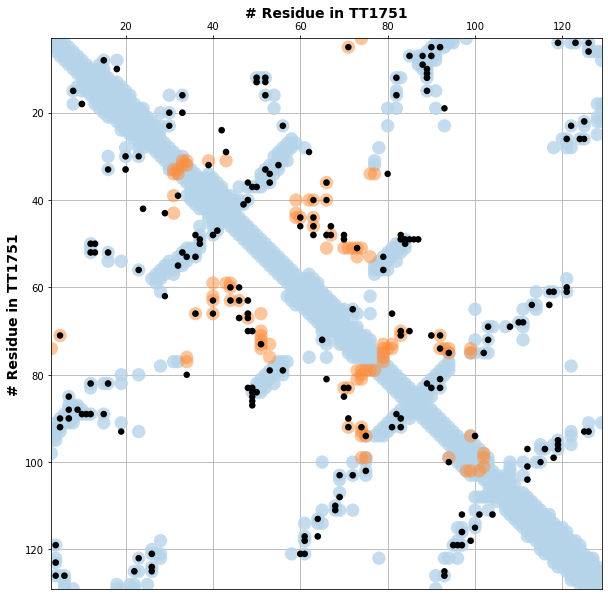

In [34]:
fig = plt.figure(figsize=(9, 9))

# create the grid for plotting
gs = gridspec.GridSpec(
        num_chains, num_chains, width_ratios=ratios,
        height_ratios=ratios
)

# create a list of axes to run through with according axes scaling
ax = [None]*num_chains**2 
for i in range(0,num_chains**2,1):
    ax[i] = plt.subplot(gs[i])
    
    ax[i].grid(True, which='major') #gridlines under plot so it's easier to trace contacts
    ax[i].set_axisbelow(True)
                        
    #ax[i].annotate('ax'+str(i),(0.5, 0.5)) #you can use this to see which ax is which
    
# format plotting by passing kwargs to function as dict
STYLE_CONTACT = {
    "edgecolor": "none",
    "c": "#b6d4e9",
    "alpha": 0.8,
    "s": 150,
}

STYLE_CONTACT_MULTIMER = {
    "edgecolor": "none",
    "c": "#fc8c3b",
    "alpha": 0.5,
    "s": 150,
}

STYLE_EC = {
    "edgecolor": "none",
    "c": "black",
    "s": 75,
}
    
# contact map plotting per each ax
# to reverse the ecs and contact maps for transposed interaction plots in the top right corners, 
# - .rename(columns={"i": "j", "j": "i"}) for the ecs
# - .transpose() the distancemap
# - list(reversed(boundaries)) to invert the axis dimensions
# - symmetric=False, multimer = None
# you can copy and paste the plots but must edit the according input data and axis information

# intramolecular couplings

plot_contact_map(
            Pthresh(intra_A['TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv'],Pcutoff), 
            monomer_distancemaps['1j3m_assembly_adjusted.pdb/B'],
            multimer =  DistanceMap.aggregate(
                intra_distancemaps['1j3m_assembly_adjusted.pdb/AB'],
                intra_distancemaps['1j3m_assembly_adjusted.pdb/BA']
                                             ),
            ax=ax[0], symmetric=True, margin = 0, 
            distance_cutoff = dist_thresh, boundaries = intraA_boundaries,
            monomer_style = STYLE_CONTACT, multimer_style = STYLE_CONTACT_MULTIMER, ec_style=STYLE_EC
)

# some custom gusto with the axis labelling
ax[0].set_xlabel('# Residue in TT1751', fontsize = 14, fontweight = 'bold')
ax[0].xaxis.set_label_position('top')
ax[0].set_ylabel('# Residue in TT1751', fontsize = 14, fontweight = 'bold')
ax[0].yaxis.set_label_position('left')

fig.tight_layout(pad = 3.0, h_pad = -1, w_pad = 1) # tight padding in plot, no big gaps



In [35]:
# save the contact map plot if it's correct :)
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/TT1751/Plots"
filename = "TT1751_1J3M_dimer_contacts_b0.8.png"

fileout = outpath+'/'+filename
fig.savefig(fileout, bbox_inches='tight', dpi=300)

# Distance vs. score plots

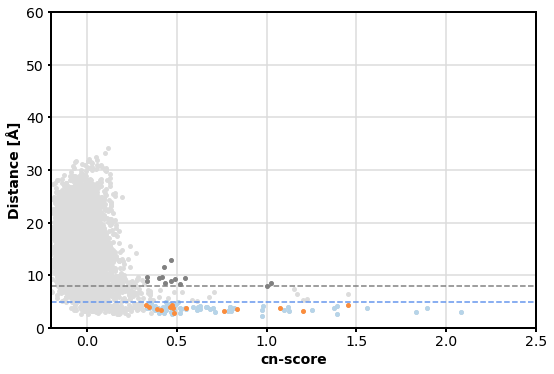

In [36]:
# probability threshold
Pcutoff = 0.9
# distance threshold
dist_thresh = 5 # stringent contact distance (usually 5 angstrom)
dist_thresh_large = 8 # maximum distance to consider something a contact (usually 8 angstrom)

# distancemap for plotting
agg_intra_distancemapA = DistanceMap.aggregate(
                intra_distancemaps['1j3m_assembly_adjusted.pdb/AB'],
                intra_distancemaps['1j3m_assembly_adjusted.pdb/BA']
)

# add the computed distances to the coupling table and plot the data
tbl_cc = coupling_scores_compared(
    intra_A['TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv'], 
    monomer_distancemaps['1j3m_assembly_adjusted.pdb/B'], 
    dist_map_multimer = agg_intra_distancemapA,
    dist_cutoff=dist_thresh
)

fig = plt.figure(figsize=(7.5, 5))
ax1 = fig.subplots()

#indexing for coloring - separate table into multimer contacts and monomer contacts
idx = Pthresh(tbl_cc,0)['dist_intra']<=Pthresh(tbl_cc,0)['dist_multimer']
tbl_monomer = Pthresh(tbl_cc[idx],Pcutoff)
tbl_multimer = Pthresh(tbl_cc[~idx],Pcutoff)

#threshold lines for distance threshold and cn-score threshold
ax1.axhline(y=dist_thresh, color="cornflowerblue", linestyle='--', linewidth=1.5)
ax1.axhline(y=dist_thresh_large, color="grey", linestyle='--', linewidth=1.5)

#index based on distance threshold to color
idx_dist_thresh_monomer = Pthresh(tbl_monomer,Pcutoff)['dist']<=dist_thresh

#idx_dist_thresh_large_monomer = (Pthresh(tbl_monomer,Pcutoff)['dist']<=dist_thresh_large) & \
#        (dist_thresh<Pthresh(tbl_monomer,Pcutoff)['dist'])

idx_unsatisfied_monomer = Pthresh(tbl_monomer,Pcutoff)['dist']>dist_thresh_large

idx_dist_thresh_multimer = Pthresh(tbl_multimer,Pcutoff)['dist']<=dist_thresh

#idx_dist_thresh_large_multimer = (Pthresh(tbl_multimer,Pcutoff)['dist']<=dist_thresh_large) & \
#        (dist_thresh<Pthresh(tbl_multimer,Pcutoff)['dist'])

idx_unsatisfied_multimer = Pthresh(tbl_multimer,Pcutoff)['dist']>dist_thresh_large

# scatter plots for couplings, cn-score vs. distance
ax1.scatter(Pthresh(tbl_cc,0)['cn'],
            Pthresh(tbl_cc,0)['dist'], s=15, c="gainsboro")

s1 = ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_monomer]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_monomer]['dist'], 
           s=15, c="#b6d4e9")
#s3 = ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_large_monomer]['cn'],
#            Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_large_monomer]['dist'], 
#           s=15, c="cornflowerblue")
s5 = ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_unsatisfied_monomer]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_unsatisfied_monomer]['dist'], 
           s=15, c="grey")

s2 = ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_multimer]['cn'],
            Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_multimer]['dist'], 
           s=15, c="#fc8c3b")
#s3 = ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_large_multimer]['cn'],
#            Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_large_multimer]['dist'], 
#           s=15, c="tomato")
s6 = ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_unsatisfied_multimer]['cn'],
            Pthresh(tbl_multimer,Pcutoff)[idx_unsatisfied_multimer]['dist'], 
           s=15, c="grey")


# some custom gusto with the axis labelling
# some custom gusto with the axis labelling
ax1.set_xlabel('cn-score', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Distance [Å]', fontsize = 14, fontweight = 'bold')
ax1.grid(True, which='major', linewidth = 1.5, color = 'gainsboro')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_axisbelow(True)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
# increase tick width
ax1.tick_params(width=2)

ax1.set_xlim(-0.2,2.5)
ax1.set_ylim(0,60)

fig.tight_layout(pad = 0, h_pad = 0, w_pad = 0) # tight padding in plot, no big gaps

plt.show()

In [37]:
# save the plot and coupling data
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/TT1751/Plots"
filename = "TT1751_1J3M_dimer_statistics_b0.8"

fileout = outpath+'/dimer/'+filename+'.png'
fig.savefig(fileout, bbox_inches='tight', dpi=300)

In [38]:
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/TT1751/Coupling Data/dimer"
tbl_monomer.to_csv(outpath+'/TT1751_1J3M_dimer_intra_couplings_b0.8.csv',
                                    index = False, sep = ',')
tbl_multimer.to_csv(outpath+'/TT1751_1J3M_dimer_inter_couplings_b0.8.csv',
                                    index = False, sep = ',')

# Write to ChimeraX plotting scripts

In [39]:
# provide list of chains in PDB file to map couplings on
chainlist = ["A","B"]

# get the i to j couplings and write to file that can be loaded into ChimeraX

outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVcouplings mapped on Alphafold complexes/TT1751/ChimeraX scripts/"
with open(outpath+'/TT1751_1J3M_dimer_couplings_plot_intra_all_b0.8.cxc', 'w+') as txtfile:
    
    #preformatting
    txtfile.write("""# ChimeraX script: Plot monomer couplings on ald hexamer
hide atoms
show cartoons
color bychain
color byhetero
style stick
graphics silhouettes true color black
lighting soft

# Monomer couplings P>0.9 sorted by cn-score""")
    
    for jdx in list(tbl_monomer.index):  
        flg = True #flag to write header on first line only
        
        #coloring based on distance as in pie chart        
        if tbl_monomer['dist'][jdx]<=dist_thresh:
            txtfile.write("\n")
            col = "#B6D4E9"
            arg = 'CONTACT_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
        elif (tbl_monomer['dist'][jdx]<=dist_thresh_large) & \
        (dist_thresh<tbl_monomer['dist'][jdx]):
            txtfile.write("\n")
            col = "#6495ED"
            arg = 'CONTACT_FAR_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
        elif Pthresh(tbl_monomer,Pcutoff)['dist'][jdx]>dist_thresh_large:
            txtfile.write("\n")
            col = "grey"
            arg = 'UNSATISFIED_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
    txtfile.write("\nhide H")

with open(outpath+'/TT1751_1J3M_dimer_couplings_plot_inter_all_b0.8.cxc', 'w') as txtfile:                
                
    #preformatting
    txtfile.write("""# ChimeraX script: Plot multimer couplings on ald hexamer
show cartoons
color bychain
color byhetero
style stick
graphics silhouettes true color black
lighting soft

# Multimer couplings P>0.9 sorted by cn-score""")               
       
    for jdx in list(tbl_multimer.index):  
        flg = True #flag to write header on first line only
        
        #coloring based on distance as in pie chart        
        if tbl_multimer['dist'][jdx]<=dist_thresh:
            txtfile.write("\n")
            col = "#FC8C3B"
            arg = 'CONTACT_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
            
        elif (tbl_multimer['dist'][jdx]<=dist_thresh_large) & \
        (dist_thresh<tbl_multimer['dist'][jdx]):
            txtfile.write("\n")
            col = "tomato"
            arg = 'CONTACT_FAR_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
            
        elif tbl_multimer['dist'][jdx]>dist_thresh_large:
            txtfile.write("\n")
            col = "grey"
            arg = 'UNSATISFIED_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
    
    txtfile.write("\nhide H")

print('Commands written to files in '+outpath)

Commands written to files in S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVcouplings mapped on Alphafold complexes/TT1751/ChimeraX scripts/
